# Santander Customer Satisfaction

## Планы

* Байесовская оптимизация параметров:
    * hyperopt;
    * bayesboost;
    * moe;
    * https://github.com/HIPS/Spearmint.
* Оптимизировать наружную функцию на тестовых примерах на 4 моделях, вероятности 0 ил.
* Vowpal wabbit с и без полиноминальным представлением переменных.
* Стекинг, что делать с вероятностями?
* Автоматическое решение для поиска лучшей комбинации моделей, причем идеи для более быстрого поиска лучших комбинаций моделей и их параметров можно брать из байесовской оптимизации.


## Решение

### Общее начало

In [1]:
%matplotlib inline

import os
import random
import pickle
from importlib import reload

import numpy as np
import scipy as sp
import pandas as pd
import pylab

from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cross_validation import StratifiedKFold, cross_val_score

import xgboost as xgb

import ml_training.common as common
import sklensemble.ensemblers.averagers as averagers
reload(common)
reload(averagers)

<module 'sklensemble.ensemblers.averagers' from 'E:\\Documents\\Projects\\sklensemble\\ensemblers\\averagers.py'>

In [2]:
def find_constant_columns(df):
    return [column for column in df.columns if len(df[column].unique()) < 2]

In [3]:
def find_equal_columns(df):
    equal_columns = []
    for col_num, column1 in enumerate(df.columns[: -1]):
        for column2 in df.columns[col_num+1:]:
            if not (df[column1] - df[column2]).any():
                equal_columns.append(column2)
    return list(set(equal_columns))

In [4]:
RANDOM_STATE = 100
random.seed(RANDOM_STATE)

In [5]:
train_df = pd.read_csv(os.path.join("input", "train.csv"))

In [6]:
constant_columns = find_constant_columns(train_df)
equal_columns = find_equal_columns(train_df)
drop_columns = list(set(constant_columns).union(equal_columns))

In [7]:
train_df.drop(drop_columns, inplace=True, axis=1)

In [8]:
train_x = train_df.loc[:, "var3": "var38"]
train_y = train_df["TARGET"]

In [53]:
if_mask = common.get_independent_features_mask(train_x.values, tol=5e-7, is_plot=False) # 5e-7
uncorr_mask = common.find_corr_features_mask(train_x.values, trashhold=0.995) # 0.995
res_mask = if_mask & uncorr_mask
if_mask.sum(), uncorr_mask.sum(), res_mask.sum()

(256, 255, 222)

In [54]:
train_x_if = train_x.loc[:, if_mask]
train_x_uc = train_x.loc[:, uncorr_mask]

In [11]:
cv = StratifiedKFold(train_y, 5, shuffle=True, random_state=RANDOM_STATE)

### Создание классификаторов

In [55]:
xgbc = xgb.XGBClassifier(n_estimators=570, max_depth=5, seed=1234, colsample_bytree=0.7, learning_rate=0.02,
                         subsample=0.68)

In [56]:
xgbc_weighted = xgb.XGBClassifier(n_estimators=570, max_depth=5, seed=1234, colsample_bytree=0.7, learning_rate=0.02,
                                  subsample=0.68)

In [57]:
xgbc_if = xgb.XGBClassifier(n_estimators=570, max_depth=5, seed=1234, colsample_bytree=0.7, learning_rate=0.02,
                            subsample=0.68)

In [58]:
xgbc_uc = xgb.XGBClassifier(n_estimators=570, max_depth=5, seed=1234, colsample_bytree=0.7, learning_rate=0.02,
                            subsample=0.68)

In [74]:
bc = averagers.BlendingClassifier([xgbc, xgbc_weighted], [False, True])

### Grid search

In [ ]:
params = {"n_estimators": [150], "max_depth": [3], "seed": [RANDOM_STATE]}
params = {"n_estimators": [570], "max_depth": [5], "seed": [1234], "learning_rate": [0.02], "subsample": [0.68],
          "colsample_bytree": [0.7]}
gs = GridSearchCV(xgbc, params, scoring="roc_auc", cv=cv, n_jobs=common.NCPU, refit=False, verbose=10)
gs.fit(train_x, train_y)

### Веса

In [46]:
w0 = 1
w1 = train_y.value_counts()[0] / train_y.value_counts()[1] * 0.5
weights = np.array(list((map(lambda x: w1 if x else w0, train_y))))

### Обучение классификаторов

In [61]:
xgbc.fit(train_x.values, train_y.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=570, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.68)

In [62]:
xgbc_weighted.fit(train_x.values, train_y.values, weights)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=570, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.68)

In [75]:
xgbc_if.fit(train_x_if.values, train_y.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=570, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.68)

In [76]:
xgbc_uc.fit(train_x_uc.values, train_y.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=570, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.68)

In [77]:
bc.fit(train_x.values, train_y.values, weights)

### Выходная оценка

In [27]:
test_df = pd.read_csv(os.path.join("input", "test.csv"))
test_df.drop(drop_columns, inplace=True, axis=1)
test_x = test_df.loc[:, "var3": "var38"]
test_x = test_x.loc[:, res_mask]

In [ ]:
test_y = xgbc_very_hard.predict_proba(test_x)[:, 1]

In [ ]:
common.save_output(np.array([test_df["ID"].values, test_y]).T, ["ID", "TARGET"])

### Тестирование классификаторов

In [ ]:
cross_val_score(xgbc, train_x, train_y, scoring="roc_auc", cv=cv, n_jobs=NCPU, verbose=10)

In [ ]:
params = {"n_estimators": 150, "max_depth": 3, "seed": RANDOM_STATE}
common.cross_val_score_with_weights(xgbc, train_x.values, train_y.values, weights, "roc_auc", cv)

In [ ]:
common.cross_val_score_with_weights(bc, train_x.values, train_y.values, weights, "roc_auc", cv)

In [78]:
np.corrcoef(np.vstack([xgbc.predict_proba(test_x)[:, 1], xgbc_weighted.predict_proba(test_x)[:, 1],
                       xgbc_if.predict_proba(test_x)[:, 1], xgbc_uc.predict_proba(test_x)[:, 1],
                       bc.predict_proba(test_x)[:, 1]]))

array([[ 1.        ,  0.91839517,  0.84940586,  0.26529842,  0.94880435],
       [ 0.91839517,  1.        ,  0.88373291,  0.28957672,  0.99635362],
       [ 0.84940586,  0.88373291,  1.        ,  0.48947926,  0.88865936],
       [ 0.26529842,  0.28957672,  0.48947926,  1.        ,  0.2883812 ],
       [ 0.94880435,  0.99635362,  0.88865936,  0.2883812 ,  1.        ]])

In [79]:
precision_recall_fscore_support(train_y, xgbc.predict(train_x))

(array([ 0.96129134,  1.        ]),
 array([ 1.        ,  0.02260638]),
 array([ 0.98026369,  0.04421326]),
 array([73012,  3008], dtype=int64))

In [80]:
precision_recall_fscore_support(train_y, xgbc_weighted.predict(train_x))

(array([ 0.98653772,  0.19595402]),
 array([ 0.88023886,  0.70844415]),
 array([ 0.93036183,  0.30699417]),
 array([73012,  3008], dtype=int64))

In [81]:
precision_recall_fscore_support(train_y, xgbc_if.predict(train_x))

(array([ 0.96138874,  0.34309623]),
 array([ 0.99784967,  0.02726064]),
 array([ 0.97927994,  0.05050816]),
 array([73012,  3008], dtype=int64))

In [82]:
precision_recall_fscore_support(train_y, xgbc_uc.predict(train_x))

(array([ 0.960706  ,  0.17307692]),
 array([ 0.99823317,  0.00897606]),
 array([ 0.97911013,  0.017067  ]),
 array([73012,  3008], dtype=int64))

In [83]:
precision_recall_fscore_support(train_y, bc.predict(train_x))

(array([ 0.96129134,  1.        ]),
 array([ 1.        ,  0.02260638]),
 array([ 0.98026369,  0.04421326]),
 array([73012,  3008], dtype=int64))

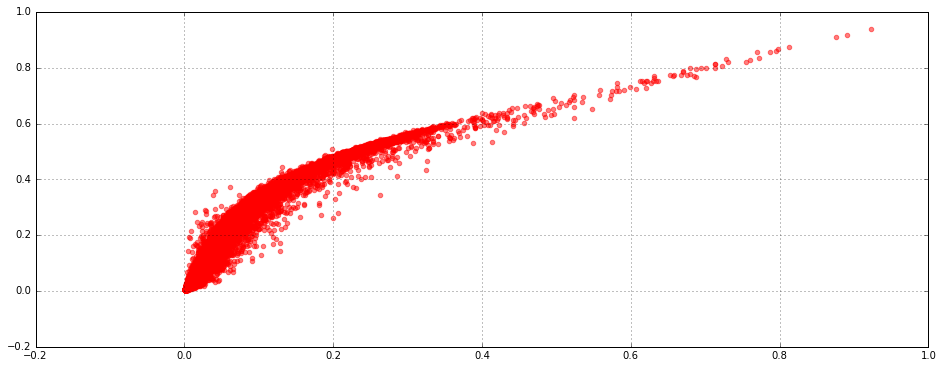

In [84]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.scatter(xgbc.predict_proba(train_x)[:, 1], bc.predict_proba(train_x)[:, 1], alpha=0.5, color = 'red')